Contenuti
===
- [Keras: reti neurali con Python](#Keras:-reti-neurali-con-Python)
- [Il dataset MNIST](#Il-dataset-MNIST)
- [*Perceptron*, SLP e MLP](#Perceptron,-SLP-e-MLP)
- [*Models*, *layers* e *deep learning*](#Models,-layers-e-deep-learning)
- [Addestramento e valutazione](#Addestramento-e-valutazione)

Keras: reti neurali con Python
---

Keras è lo strumento più avanzato di Python per le reti neurali. Supporta diversi *backend*, tra cui TensorFlow: https://www.tensorflow.org/. Può eseguire calcoli sia su CPU che GPU: https://www.quora.com/Why-are-GPUs-well-suited-to-deep-learning.

Keras mette a disposizione API di alto livello per costruire ed usare una rete neurale con pochissime righe di codice. Allo stesso tempo, è una libreria altamente modulare, flessibile e facile da estendere.

Sul web si trovano molte introduzioni alle reti neurali basate su Keras, come https://towardsdatascience.com/how-to-build-a-neural-network-with-keras-e8faa33d0ae4.


Importiamo la libreria dopo averla installata:
        
        conda install -c conda-forge keras


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

Il dataset MNIST
---
MNIST (http://yann.lecun.com/exdb/mnist/) è un dataset di 60K immagini di addestramento e 10K di test, costruito dal NIST (*National Institute of Standards and Technology*) negli anni 80. 

Ciascuna immagine rappresenta un numero scritto a mano. *Risolvere* MNIST, cioè imparare ad assegnare ad una immagine il numero corretto, è considerato l'"Hello, world!" delle reti neurali.

Importiamo MNIST attraverso il modulo *datasets* di Keras. La libreria *pickle* di Python gestisce oggetti *serializzati*, cioè salvati in formato binario.

In [2]:
from keras.datasets import mnist
import pickle

#pickle.dump(mnist.load_data(), open('data/mnist', 'wb'))

[train_images, train_labels], [test_images, test_labels] = pickle.load(open('data/mnist', 'rb'))

print('train images: {},{},{}'.format(*train_images.shape))
print('train labels: {}'.format(*train_labels.shape))
print('test images : {},{},{}'.format(*test_images.shape))
print('test labels : {}'.format(*test_labels.shape))

train images: 60000,28,28
train labels: 60000
test images : 10000,28,28
test labels : 10000


Ciascuna immagine è formata da 28\*28 pixel in scala di grigio, cioè con valori da 0 a 255.

In [3]:
import numpy as np

print('ndim    :', train_images.ndim)
print('dtype   :', train_images.dtype)
print('shape   :', train_images[0].shape)
print('min/max :', np.min(train_images), np.max(train_images))

ndim    : 3
dtype   : uint8
shape   : (28, 28)
min/max : 0 255


Visualizziamo le immagini di addestramento grazie ad una funzionalità della libreria *Matplotlib*: https://matplotlib.org/index.html.

Il magic command

    %matplotlib inline
    
permette di visualizzare implicitamente le immagini create dalla libreria.

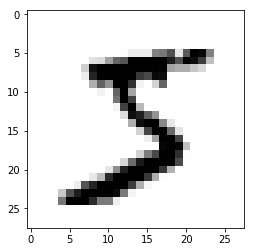

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap=plt.cm.binary)

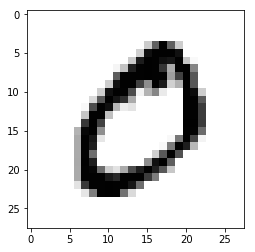

In [5]:
plt.imshow(train_images[1], cmap=plt.cm.binary)

Come abbiamo detto, le label (classi) sono 10, cioè i numeri da 0 a 9. Visualizziamone la distribuzione usando numpy e *seaborn*: https://seaborn.pydata.org/.

In [6]:
print(set(train_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
import numpy as np

print(np.bincount(train_labels))

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


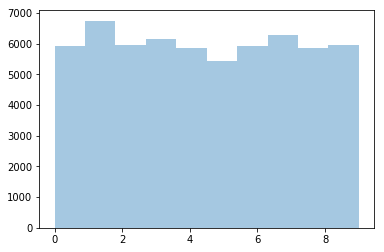

In [8]:
import seaborn as sns

sns.distplot(train_labels, bins=10, kde=False)

*Perceptron*, SLP e MLP
---
Costruiamo adesso con Keras una rete neurale, in particolare un *multi-layer perceptron* (MLP), in grado di riconoscere caratteri scritti a mano.

Come abbiamo visto, il *perceptron* è una rete formata da un solo neurone. Questa singola unità applica una funzione *gradino* alla somma pesata dei suoi ingressi. Se il risultato supera una *soglia di attivazione* (per esempio 0), il nodo risponde 1; altrimenti, 0:

![Perceptron function](https://wikimedia.org/api/rest_v1/media/math/render/svg/91b90f2214abac34f0aa9bfc48d44a3a5f96425d)

L'ottimizzazione dei pesi $w$ è l'obiettivo dell'addestramento.

Una rete con un solo livello di percettroni è detta SLP. Un MLP ha almeno un livello *hidden*, i cui nodi applicano funzioni di attivazione non lineari come la *ReLU*:

![ReLU2](https://cdn-images-1.medium.com/max/1600/0*qtfLu9rmtNullrVC.png)

Ecco un esempio di MLP:

![MLP](https://dzone.com/storage/temp/3627042-mlp-network.png)

Questa qui sopra è una rete *densa*: ogni neurone riceve input da tutti quelli del livello precedente e inoltra il risultato delle sue operazioni a tutti quelli del livello successivo.

A differenza del percettrone e di SLP, MLP è in grado di approssimare funzioni non lineari, come quella che ci serve per risolvere MNIST.

*Models*, *layers* e *deep learning*
---
*Sequential* è il modello base di rete *feed-forward* (FF-ANN) di Keras, ed è contenuto nel modulo *models*. 

Si può utilizzare Sequential per costruire un MLP, "impilando" strati diversi di neuroni.

In [9]:
from keras import models
from keras import layers

network = models.Sequential()

Il livello di input avrà tanti neuroni quante sono le feature. Nel caso di MNIST, i neuroni di input saranno tanti quanti i pixel di ogni immagine: 28\*28 = 784.

Per Keras, lo strato di input è implicito: il numero di nodi di ingresso è passato come argomento al primo livello intermedio.

Costruiamo quindi un MLP con un unico strato intermedio di 512 neuroni. Scegliamo ReLU come funzione di attivazione in uscita dal livello intermedio.

In [10]:
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))#strato hidden

Poichè le classi sono 10, serviranno 10 nodi di output. La funzione di attivazione scelta per l'uscita à *softmax*:

![Softmax](https://i2.wp.com/sefiks.com/wp-content/uploads/2017/11/softmax1.png?resize=850%2C329)

Softmax trasforma punteggi numerici (nel nostro caso, le ReLU in uscita dallo strato intermedio) in probabilità, e si presta bene alla classificazione multi-classe.

In [11]:
network.add(layers.Dense(10, activation='softmax'))#strato di output

La rete è quasi pronta. Mancano due ingredienti per poterla addestrare ed utilizzare: una funzione di *loss*, cioè un sistema di valutazione dell'errore commesso dal modello sui singoli esempi, e un *ottimizzatore*, cioè un procedimento di aggiornamento dei parametri della rete (i suoi pesi): https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f.

Quanti sono i pesi della rete che abbiamo costruito?

In [12]:
network.weights

[<tf.Variable 'dense_1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

La funzione *compile* inizializza la rete e la prepara all'addestramento.

In [13]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])#valutazione dell'errore commesso dalla rete in uscita

La rete che abbiamo costruito ha un solo livello intermedio. Con *deep learning*, da un punto di vista strutturale, si indica nient'altro che l'utilizzo di reti *profonde*, cioè con diversi strati nascosti (ciascuno con la sua funzione di attivazione).

Ognuno dei livelli di una rete può essere visto come un *filtro* per i dati. In ciascuno dei livelli l'informazione arriva in una certa forma, viene interpretata, e ne esce in una forma diversa. 

Intuitivamente, una rete profonda impara concetti semplici (di *basso livello*) nei primi strati, imparando a gestire concetti più generali e con una semantica via via più complessa (cioè, sempre di più *alto livello*) negli strati successivi:

![DeepLearning](https://fortunedotcom.files.wordpress.com/2016/09/lrn-10-01-16-neural-networks-e1474990995824.png)

Questa capacità di generalizzazione progressiva e di apprendimento di concetti è quello che rende unico il deep learning. Il salto in avanti rispetto al machine learning degli anni precedenti all'esplosione delle reti neurali profonde è il concetto di *feature learning*. Invece di progettare manualmente le caratteristiche dei dati, queste vengono imparate dalla rete, contestualmente all'apprendimento.

I primi strati di una rete profonda, se i dati di apprendimento sono sufficienti, sono in grado di *progettare* autonomamente feature (cioè concetti di basso livello), che verranno rielaborati negli strati successivi.

![FeatureLearning](https://cdn-images-1.medium.com/max/693/1*ZX05x1xYgaVoa4Vn2kKS9g.png)

Addestramento e valutazione
---
Torniamo all'addestramento della nostra rete.

Aggiustiamo i dati in modo conveniente: in particolare, vogliamo che ognuno dei 60K esempi di addestramento (le immagini) abbia 28\*28=784 feature, quanti sono i pixel. Normalizziamo anche ogni feature tra 0 e 1.

In [14]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

Come ultimo passaggio, trasformiamo le etichette attraverso la codifica one-hot.

In [15]:
from keras.utils import to_categorical

print(train_labels.shape, train_labels[0])

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels.shape, train_labels[0])

(60000,) 5
(60000, 10) [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Siamo infine pronti per addestrare e valutare le prestazione della rete. Durante l'addestramento, l'algoritmo di ottimizzazione lavora su di un sottoinsieme (*batch*) di esempi alla volta. Ad ogni *epoca* di addestramento, alla rete vengono presentati tutti gli esempi del training set.

In [19]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 3s 45us/step - loss: 0.0289 - acc: 0.9911
Epoch 2/5
60000/60000 [==============================] - 3s 46us/step - loss: 0.0232 - acc: 0.9930
Epoch 3/5
60000/60000 [==============================] - 3s 45us/step - loss: 0.0174 - acc: 0.9949
Epoch 4/5
60000/60000 [==============================] - 3s 46us/step - loss: 0.0131 - acc: 0.9961
Epoch 5/5
60000/60000 [==============================] - 3s 45us/step - loss: 0.0107 - acc: 0.9967


In [20]:
network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 34us/step


[0.07713993792594774, 0.9793]

Grazie a Keras, con circa 20 righe di codice abbiamo costruito una rete neurale MLP che ottiene un'accuratezza di circa il 98% su di un problema di classificazione di immagini.

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('div.prompt').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by Rackspace.
</footer>